In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

from tqdm import tqdm

from keras.utils import to_categorical
from keras.models import Model, load_model, Sequential
from keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Input, Dropout, Conv2DTranspose, Add
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
from keras import backend as K

from sklearn.model_selection import train_test_split

In [38]:
# Load Data into corresponding array

def load_data(path: str):
  dir = sorted(os.listdir(path))
  data = []
  gt = []

  for patient in tqdm(dir):
    current_path = path + patient + '/'
    data_list = sorted(os.listdir(current_path))

    tmp_img = sitk.ReadImage(current_path + data_list[0])
    flair = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[1])
    seg = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[2])
    t1 = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[3])
    t1ce = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[4])
    t2 = sitk.GetArrayFromImage(tmp_img)

    data.append([flair, t1, t1ce, t2])
    gt.append(seg)

  data = np.asarray(data, dtype = np.float32)
  gt = np.asarray(gt, dtype = np.uint8)
  return data, gt


data, gt = load_data("Dataset/")



100%|██████████| 12/12 [00:01<00:00,  9.76it/s]


In [39]:
# Reorganise the data
data = np.transpose(data, (0, 2, 3, 4, 1))

In [40]:
# Filter the unusuable slices out of the images
data = data[:, 30:120, 30:222, 30:222, :].reshape([-1, 192, 192, 4])   

gt = gt[:, 30:120, 30:222, 30:222].reshape([-1, 192, 192, 1])
gt[np.where(gt == 4)] = 3

In [41]:
# Just as in the ISEG challenge we create a training, validation and test arrays
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(data, gt, test_size = 0.2, random_state = 69)
XTRAIN, XVAL, YTRAIN, YVAL = train_test_split(XTRAIN, YTRAIN, test_size = 0.25, random_state = 69)

In [42]:
# We label each image
YTRAIN = to_categorical(YTRAIN)
YVAL = to_categorical(YVAL)

In [43]:
# We normalize the images for pre-processing
XTRAIN = (XTRAIN - np.mean(XTRAIN)) / np.max(XTRAIN)
XTEST = (XTEST - np.mean(XTEST)) / np.max(XTEST)
XVAL = (XVAL - np.mean(XVAL)) / np.max(XVAL)

In [44]:
# Functions to get the dice coeficients
def dice_coef(y_true, y_pred, epsilon = 1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    return (2. * intersection) / (K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis = -1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Encoding / Decoding Neural Network
I have based this neural network on the following paper, the detailed explanation of how it works can be found here
https://scholar.google.com/scholar_url?url=https://www.mdpi.com/2075-4418/11/2/169/pdf&hl=en&sa=X&ei=-einZOmRJ92Sy9YP2fyhwAg&scisig=ABFrs3yeUhayVRfJMdM5VFI6lb78&oi=scholarr

In [45]:
# Fist encoder

input_shape = Input(shape = (192, 192, 4))

encoder_1_conv_1 = Conv2D(32, 3, padding = 'same', activation = 'relu') (input_shape)
encoder_1_norm_1 = BatchNormalization() (encoder_1_conv_1)
encoder_1_conv_2 = Conv2D(32, 3, padding = 'same', activation = 'relu') (encoder_1_norm_1)
encoder_1_norm_2 = BatchNormalization() (encoder_1_conv_2)
encoder_1_pool_1  = MaxPooling2D() (encoder_1_norm_2)
encoder_1_conv_3 = Conv2D(64, 3, padding = 'same', activation = 'relu') (encoder_1_pool_1)
encoder_1_norm_3 = BatchNormalization() (encoder_1_conv_3)
encoder_1_conv_4 = Conv2D(64, 3, padding = 'same', activation = 'relu') (encoder_1_norm_3)
encoder_1_norm_4 = BatchNormalization() (encoder_1_conv_4)
encoder_1_pool_2  = MaxPooling2D() (encoder_1_norm_4)
encoder_1_conv_5 = Conv2D(128, 3, padding = 'same', activation = 'relu') (encoder_1_pool_2)
encoder_1_norm_5 = BatchNormalization() (encoder_1_conv_5)
encoder_1_conv_6 = Conv2D(128, 3, padding = 'same', activation = 'relu') (encoder_1_norm_5)
encoder_1_norm_6 = BatchNormalization() (encoder_1_conv_6)
encoder_1_pool_3  = MaxPooling2D() (encoder_1_norm_6)

encoder_1_dropout_1 = Dropout(0.2) (encoder_1_pool_3)

encoder_1_conv_7 = Conv2D(256, 3, padding = 'same', activation = 'relu') (encoder_1_dropout_1)
encoder_1_norm_7 = BatchNormalization() (encoder_1_conv_7)
encoder_1_conv_8 = Conv2D(256, 3, padding = 'same', activation = 'relu') (encoder_1_norm_7)
encoder_1_norm_8 = BatchNormalization() (encoder_1_conv_8)
encoder_1_pool_3  = MaxPooling2D() (encoder_1_norm_8)
encoder_1_conv_9 = Conv2D(512, 3, padding = 'same', activation = 'relu') (encoder_1_pool_3)
encoder_1_norm_9 = BatchNormalization() (encoder_1_conv_9)
encoder_1_conv_10 = Conv2D(512, 3, padding = 'same', activation = 'relu') (encoder_1_norm_9)
encoder_1_norm_10 = BatchNormalization() (encoder_1_conv_10)
encoder_1_pool_4  = MaxPooling2D() (encoder_1_norm_10)
encoder_1_conv_11 = Conv2D(1024, 3, padding = 'same', activation = 'relu') (encoder_1_pool_4)

In [46]:
# First decoder
decoder_1_up_1 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu') (encoder_1_conv_11)
decoder_1_merge_1 = Add() ([encoder_1_norm_9, encoder_1_norm_10, decoder_1_up_1])
decoder_1_conv_1 = Conv2D(512, 3, padding = 'same', activation = 'relu') (decoder_1_merge_1)
decoder_1_up_2 = Conv2DTranspose(256, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_1_conv_1)
decoder_1_merge_2 = Add() ([encoder_1_norm_7, encoder_1_norm_8, decoder_1_up_2])
decoder_1_conv_2 = Conv2D(256, 3, padding = 'same', activation = 'relu') (decoder_1_merge_2)

decoder_1_dropout_1 = Dropout(0.2) (decoder_1_conv_2)

decoder_1_up_3 = Conv2DTranspose(128, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_1_dropout_1)
decoder_1_merge_3 = Add() ([encoder_1_norm_5, encoder_1_norm_6 , decoder_1_up_3])
decoder_1_conv_3 = Conv2D(128, 3, padding = 'same', activation = 'relu') (decoder_1_merge_3)
decoder_1_up_4 = Conv2DTranspose(64, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_1_conv_3)
decoder_1_merge_4 = Add() ([encoder_1_norm_3, encoder_1_norm_3, decoder_1_up_4])
decoder_1_conv_4 = Conv2D(64, 3, padding = 'same', activation = 'relu') (decoder_1_merge_4)
decoder_1_up_5 = Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_1_conv_4)
decoder_1_merge_5 = Add() ([encoder_1_norm_1, encoder_1_norm_2 , decoder_1_up_5])
decoder_1_conv_5 = Conv2D(32, 3, padding = 'same', activation = 'relu') (decoder_1_merge_5)

In [47]:
# Second encoder
encoder_2_conv_1 = Conv2D(32, 3, padding = 'same', activation = 'relu') (decoder_1_conv_5)
encoder_2_norm_1 = BatchNormalization() (encoder_2_conv_1)
encoder_2_conv_2 = Conv2D(32, 3, padding = 'same', activation = 'relu') (encoder_2_norm_1)
encoder_2_norm_2 = BatchNormalization() (encoder_2_conv_2)
encoder_2_pool_1  = MaxPooling2D() (encoder_2_norm_2)

encoder_2_conv_3 = Conv2D(64, 3, padding = 'same', activation = 'relu') (encoder_2_pool_1)
encoder_2_norm_3 = BatchNormalization() (encoder_2_conv_3)
encoder_2_conv_4 = Conv2D(64, 3, padding = 'same', activation = 'relu') (encoder_2_norm_3)
encoder_2_norm_4 = BatchNormalization() (encoder_2_conv_4)
encoder_2_pool_2  = MaxPooling2D() (encoder_2_norm_4)

encoder_2_conv_5 = Conv2D(128, 3, padding = 'same', activation = 'relu') (encoder_2_pool_2)
encoder_2_norm_5 = BatchNormalization() (encoder_2_conv_5)
encoder_2_conv_6 = Conv2D(128, 3, padding = 'same', activation = 'relu') (encoder_2_norm_5)
encoder_2_norm_6 = BatchNormalization() (encoder_2_conv_6)
encoder_2_pool_3  = MaxPooling2D() (encoder_2_norm_6)

encoder_2_dropout_1 = Dropout(0.2) (encoder_2_pool_3)

encoder_2_conv_7 = Conv2D(256, 3, padding = 'same', activation = 'relu') (encoder_2_dropout_1)
encoder_2_norm_7 = BatchNormalization() (encoder_2_conv_7)
encoder_2_conv_8 = Conv2D(256, 3, padding = 'same', activation = 'relu') (encoder_2_norm_7)
encoder_2_norm_8 = BatchNormalization() (encoder_2_conv_8)
encoder_2_pool_3  = MaxPooling2D() (encoder_2_norm_8)

encoder_2_conv_9 = Conv2D(512, 3, padding = 'same', activation = 'relu') (encoder_2_pool_3)
encoder_2_norm_9 = BatchNormalization() (encoder_2_conv_9)
encoder_2_conv_10 = Conv2D(512, 3, padding = 'same', activation = 'relu') (encoder_2_norm_9)
encoder_2_norm_10 = BatchNormalization() (encoder_2_conv_10)
encoder_2_pool_4  = MaxPooling2D() (encoder_2_norm_10)

encoder_2_conv_11 = Conv2D(1024, 3, padding = 'same', activation = 'relu') (encoder_2_pool_4)

In [48]:
# Second decoder
decoder_2_up_1 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu') (encoder_2_conv_11)
decoder_2_merge_1 = Add() ([encoder_2_norm_9, encoder_2_norm_10, decoder_2_up_1])
decoder_2_conv_1 = Conv2D(512, 3, padding = 'same', activation = 'relu') (decoder_2_merge_1)
decoder_2_up_2 = Conv2DTranspose(256, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_2_conv_1)
decoder_2_merge_2 = Add() ([encoder_2_norm_7, encoder_2_norm_8, decoder_2_up_2])
decoder_2_conv_2 = Conv2D(256, 3, padding = 'same', activation = 'relu') (decoder_2_merge_2)

decoder_2_dropout_1 = Dropout(0.2) (decoder_2_conv_2)

decoder_2_up_3 = Conv2DTranspose(128, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_2_dropout_1)
decoder_2_merge_3 = Add() ([encoder_2_norm_5, encoder_2_norm_6 , decoder_2_up_3])
decoder_2_conv_3 = Conv2D(128, 3, padding = 'same', activation = 'relu') (decoder_2_merge_3)
decoder_2_up_4 = Conv2DTranspose(64, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_2_conv_3)
decoder_2_merge_4 = Add() ([encoder_2_norm_3, encoder_2_norm_3, decoder_2_up_4])
decoder_2_conv_4 = Conv2D(64, 3, padding = 'same', activation = 'relu') (decoder_2_merge_4)
decoder_2_up_5 = Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same', activation = 'relu') (decoder_2_conv_4)
decoder_2_merge_5 = Add() ([encoder_2_norm_1, encoder_2_norm_2 , decoder_2_up_5])
decoder_2_conv_5 = Conv2D(32, 3, padding = 'same', activation = 'relu') (decoder_2_merge_5)

pre_output = Conv2D(32, 1, padding = 'same', activation = 'relu') (decoder_2_merge_5)
output = Conv2D(4, 1, padding = 'same', activation = 'softmax') (pre_output)

In [49]:
# Final model 
model = Model(inputs = input_shape, outputs = output)

In [50]:
# Compile the model
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Load pre trained model
# model = load_model('saved_model/my_model')
model.load_weights('pretrained_weights/NN-Weights-3.h5')


In [52]:
# Train the model and save the history
# csv_logger = CSVLogger('training-3.log', separator = ',', append = False)
# history = model.fit(XTRAIN, YTRAIN, batch_size = 8, epochs = 20, verbose = 1, validation_data = (XVAL, YVAL), shuffle = True, callbacks = [csv_logger])

Epoch 1/20
81/81 [==============================] - 209s 3s/step - loss: 0.2229 - accuracy: 0.8815 - val_loss: 0.1472 - val_accuracy: 0.9729
Epoch 2/20
81/81 [==============================] - 192s 2s/step - loss: 0.0300 - accuracy: 0.9797 - val_loss: 0.3048 - val_accuracy: 0.9730
Epoch 3/20
81/81 [==============================] - 193s 2s/step - loss: 0.0222 - accuracy: 0.9827 - val_loss: 0.2889 - val_accuracy: 0.9730
Epoch 4/20
81/81 [==============================] - 194s 2s/step - loss: 0.0178 - accuracy: 0.9852 - val_loss: 0.0896 - val_accuracy: 0.9730
Epoch 5/20
81/81 [==============================] - 196s 2s/step - loss: 0.0151 - accuracy: 0.9875 - val_loss: 0.1459 - val_accuracy: 0.9730
Epoch 6/20
81/81 [==============================] - 194s 2s/step - loss: 0.0132 - accuracy: 0.9898 - val_loss: 0.0506 - val_accuracy: 0.9774
Epoch 7/20
81/81 [==============================] - 192s 2s/step - loss: 0.0130 - accuracy: 0.9905 - val_loss: 0.0321 - val_accuracy: 0.9839
Epoch 8/20
81

In [53]:
# Save the model & weights
# model.save('saved_model/my_model-3')
# model.save_weights('pretrained_weights/NN-Weights-3.h5')

INFO:tensorflow:Assets written to: saved_model/my_model-3/assets


INFO:tensorflow:Assets written to: saved_model/my_model-3/assets


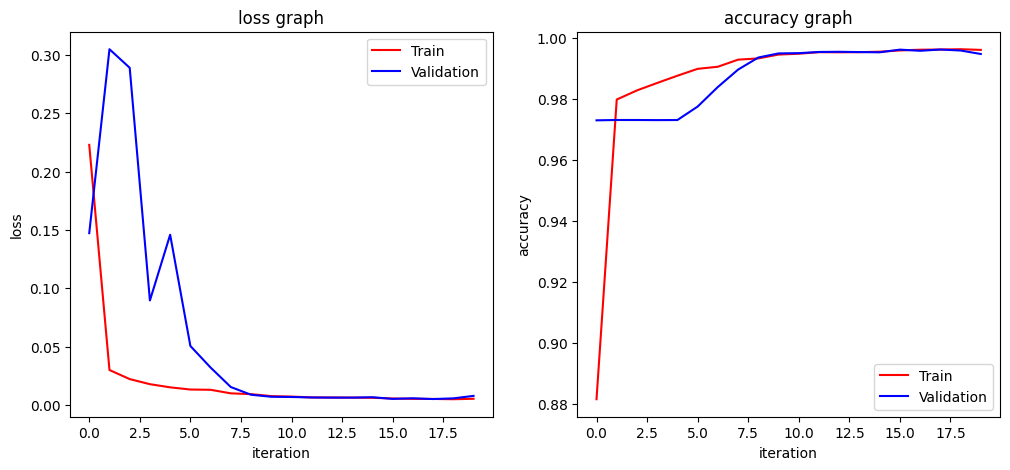

In [55]:
# Training history
training_logs = pd.read_csv('training-3.log', sep = ',', engine = 'python')

list_train_dice = training_logs['accuracy']
list_validation_dice = training_logs['val_accuracy']

list_train_loss = training_logs['loss']
list_validation_loss = training_logs['val_loss']

fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(list_train_loss, 'r-', label = "Train")
axes[0].plot(list_validation_loss, 'b-', label = "Validation")
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('loss')
axes[0].legend()
axes[0].title.set_text('loss graph')

axes[1].plot(list_train_dice, 'r-', label = "Train")
axes[1].plot(list_validation_dice, 'b-', label = "Validation")
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('accuracy')
axes[1].legend()
axes[1].title.set_text('accuracy graph')

fig.show()


# Résultats

In [58]:
# Get Overall Results
Y_test_encod = to_categorical(YTEST)
train_result = model.evaluate(XTRAIN, YTRAIN, verbose = 0)
test_result = model.evaluate(XTEST, Y_test_encod, verbose = 0)
val_result = model.evaluate(XVAL, YVAL, verbose = 0)



Le tableau ci dessous, résume les performances de notre model sur les différents sets de data 

In [59]:
pd.set_option("display.precision", 10)
pd.DataFrame([train_result,test_result,val_result], columns = ["Loss", "Dice Coefficient"], index = ["Train", "Validation", "Test"] )


,Loss,Dice Coefficient
Train,0.0067898990,0.9949942231
Validation,0.0087538529,0.9937656522
Test,0.0077790329,0.9946595430
